In [1]:
%load_ext autoreload
%autoreload 2
from dataset import prepare, assemble
import dataset.transform as tfm
import regressor
import utils
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Conv2D, Flatten, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications import ResNet50
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix
from plot_utils import show_some, image_grid
import random
import tensorflow as tf

Using TensorFlow backend.


In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.set_random_seed(seed)

In [3]:
def not_bad(row: pd.Series):
    import json
    labels = json.load(open('/data/staff/common/ML-crystals/classification/better_labels.json', 'r'))
    return labels['{}_{}'.format(row['sample'], 'H2' if row['scan'].startswith('2018') else 'H1')] != 'bad'

In [4]:
def myresnet():
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(128,128,3))
    for layer in base.layers:
        layer.trainable=False
    x = base.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(.5)(x)
    end = Dense(1, activation='linear')(x)
    md = Model(input=base.input, output=end)
    md.compile(optimizer=Adam(lr=1e-5), loss='mean_squared_error', metrics=['mae'])
    return md

def build_model():
    md = Sequential()
    md.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=regressor.INPUT_SHAPE))
    md.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
    md.add(Flatten())
    md.add(Dense(32, activation='relu'))
    md.add(Dense(1, activation='relu'))
    md.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return md

def build_model2():
    nb_filters = 8
    kernel_size = 3
    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size, input_shape=(128,128,1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(nb_filters, kernel_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.25)) # experiment

    model.add(Conv2D(nb_filters, kernel_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(nb_filters, kernel_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(nb_filters*2, kernel_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(nb_filters*2, kernel_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.25)) # experiment

    #model.add(Conv2D(nb_filters*2, kernel_size))
    #model.add(Activation('relu'))

    #model.add(Conv2D(nb_filters*2, kernel_size))
    #model.add(Activation('relu'))
    #model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(265))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(127))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('linear'))
    
    opt = Adam(lr=1e-6)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
    return model

def arch(l: list, loss='mean_squared_error', final_act='linear'):
    nb_filters = 8
    kernel_size = 3
    model = Sequential()
    
    for i in range(l[0]):
        model.add(Conv2D(nb_filters, kernel_size, **(dict(input_shape=(128,128,1)) if i==0 else dict())))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
    
    if l[1] > 0:
        model.add(MaxPool2D())
    
    for i in range(l[2]):
        model.add(Conv2D(nb_filters*2, kernel_size))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    for i in range(l[3]):
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
    
    for i in range(l[4]):
        model.add(Dense(128))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        
    for i in range(l[5]):
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation(final_act))
    
    opt = Adam(lr=1e-6)
    model.compile(loss=loss, optimizer=opt, metrics=['mae'])
    return model

def derp_arch():
    model = Sequential()
    
    model.add(Conv2D(8, 3, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['binary_accuracy'])
    return model


def test_data():
    regressor.INPUT_SHAPE = (128, 128, 3)
    df = pd.read_csv('/data/staff/common/ML-crystals/fakeset2/fake.csv')
    # zero_y = df[df['y']==0]
    # df = df.drop(zero_y.sample(frac=0.5).index)
    print(len(df))
    # df = df.sample(frac=0.5)

    f_sample = lambda f: Path(f).parts[7:8][0]
    samples = set(df['filename'].map(f_sample))
    train, test = train_test_split(list(samples), test_size=0.4, random_state=42)
    valid, test = train_test_split(list(samples - set(train)), test_size=0.5, random_state=42)

    train_idx = df['filename'].map(f_sample).isin(train)
    test_idx = df['filename'].map(f_sample).isin(test)
    valid_idx = df['filename'].map(f_sample).isin(valid)
    f_load_img = lambda f: np.stack(cv.imread(f))
    train_x, train_y = df[train_idx]['filename'].map(f_load_img), df[train_idx]['y'].values
    test_x, test_y = df[test_idx]['filename'].map(f_load_img), df[test_idx]['y'].values
    valid_x, valid_y = df[valid_idx]['filename'].map(f_load_img), df[valid_idx]['y'].values

    train_x = np.stack(train_x).reshape(len(train_x), *regressor.INPUT_SHAPE)
    test_x = np.stack(test_x).reshape(len(test_x), *regressor.INPUT_SHAPE)
    valid_x = np.stack(valid_x).reshape(len(valid_x), *regressor.INPUT_SHAPE)
    model = build_model2()
    model.fit(train_x, train_y, epochs=3, batch_size=64, validation_data=(valid_x, valid_y))
    score = model.evaluate(test_x, test_y, batch_size=64)
    print(score)
    return model
    
def vali():
    res = model.predict(valid_x, batch_size=64, verbose=1)
    max_sort = np.argsort(res, axis=0)[::-1]
    print(len(max_sort))
    i = 500
    plt.imshow(valid_x[max_sort[i]].reshape((128, 128, 3)))
    plt.title(res[max_sort[i]][0]);


In [5]:
df = assemble.get_dataset_df('/data/staff/common/ML-crystals/csv/all_0.5.csv')
df.head()
print(len(df))
df = df[df.apply(not_bad, axis=1)]
#df['y'] = df['y'].apply(lambda x: 1 if x==0 else x)
#df.loc[df['y'] > 1000,'y'] = 1000
#df = df.drop(df[df['y'] < 100].sample(frac=0.8).index)


loading meta files
meta loaded
12364


### Example imgs

In [ ]:
np.mean(df['y'])

In [ ]:
good_rows = df[df['y'] > 500].sample(n=8)
image_grid(
    images=list(good_rows['filename'].apply(lambda fn: cv.imread(fn))),
    titles=list(good_rows['y'].apply(lambda y: f'reflection count: {y}'))
)

In [ ]:
bad_rows = df[df['y'] < 100].sample(n=8)
image_grid(
    images=list(bad_rows['filename'].apply(lambda fn: cv.imread(fn))),
    titles=list(bad_rows['y'].apply(lambda y: f'reflection count: {y}'))
)

In [ ]:
plt.xlabel('raw reflection count')
plt.ylabel('number of images')
plt.hist(df['y'],bins=50)

### Transform

In [6]:
tconf = dict(
    input_shape=(128,128,1)
)

In [7]:
def trans_log(df: pd.DataFrame) -> pd.DataFrame:
    # filtering
    df = df[df['y'] > 0]
    
    tdf = tfm.load_and_znorm(df, tconf)
    tdf = tfm.row_map(tdf, 'img', tfm.normed_img)
    
    # y-values
    tdf = tfm.log_y(tdf, tconf)
    tdf = tfm.norm_y(tdf, tconf)
    
    # augmentation
    tdf = tfm.aug_hflip(tdf)
    tdf = tfm.aug_rotate(tdf, tconf)
    
    return tdf

def trans_tanh(df: pd.DataFrame) -> pd.DataFrame:
    # images
    tdf = tfm.load_and_znorm(df, tconf)
    tdf = tfm.row_map(tdf, 'img', tfm.normed_img)
    
    # y-values
    tdf = tfm.norm_y(tdf, tconf)
    tdf['y'] = tdf['y'].apply(np.tanh)
    
    # augmentation
    tdf = tfm.aug_hflip(tdf)
    tdf = tfm.aug_rotate(tdf, tconf)
    
    return tdf

def trans_vanilla(df: pd.DataFrame) -> pd.DataFrame:
    # images
    tdf = tfm.load_and_znorm(df, tconf)
    tdf = tfm.row_map(tdf, 'img', tfm.normed_img)
    
    # y-values
    tdf = tfm.norm_y(tdf, tconf)
    
    # augmentation
    tdf = tfm.aug_hflip(tdf)
    tdf = tfm.aug_rotate(tdf, tconf)
    
    return tdf

def trans_binary(df: pd.DataFrame, thresh:int) -> pd.DataFrame:
    # images
    tdf = tfm.load_and_znorm(df, tconf)
    tdf = tfm.row_map(tdf, 'img', tfm.normed_img)
    
    # y-values
    tdf['y'] = tdf['y'].apply(lambda x: 0 if x < thresh else 1)
    #tdf = tfm.norm_y(tdf, tconf)
    
    # augmentation
    tdf = tfm.aug_hflip(tdf)
    tdf = tfm.aug_rotate(tdf, tconf)
    
    return tdf

In [8]:
tdf = trans_tanh(df)

  0%|          | 2/8646 [00:00<07:23, 19.51it/s]

row mapping row_pipeline


  2%|▏         | 208/8646 [00:00<00:04, 2077.37it/s]

row mapping normed_img


  8%|▊         | 704/8646 [00:00<00:01, 7032.26it/s]

Y normalization
flip augmentation


100%|██████████| 8646/8646 [00:01<00:00, 7573.53it/s]


rotate augmentation


In [ ]:
_ = plt.hist(tdf['y'], bins=50)

### Split

In [9]:
trn_df, val_df, tst_df = [tdf[tdf['sample'].isin(samples)] for samples in assemble.split_dataset(tdf, seed=10)] #prev 10
len(trn_df), len(val_df), len(tst_df)

(44368, 10648, 14152)

In [ ]:
# trn_df = pd.concat([trn_df, val_df], axis=0)

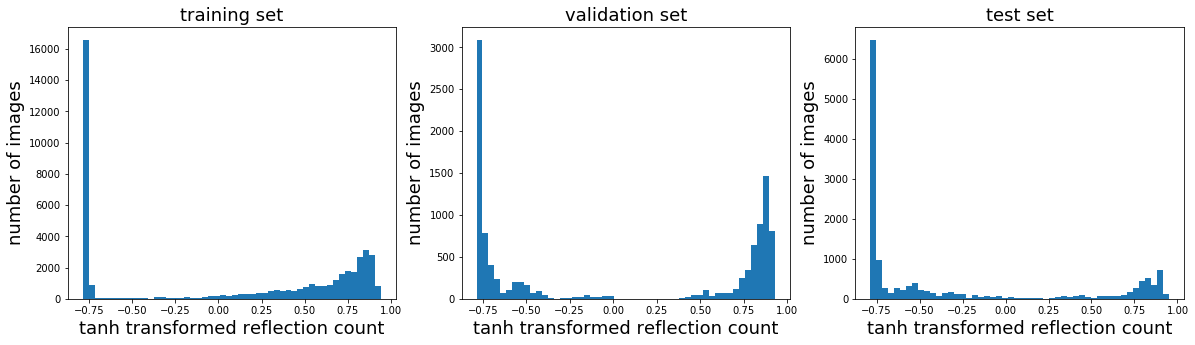

In [10]:
plt.figure(figsize=(20,5))
xlabelprefix = 'tanh '

for pl, title, df in [
    (131, 'training set', trn_df),
    (132, 'validation set', val_df),
    (133, 'test set', tst_df),
]:
    ax = plt.subplot(pl)
    fontsize = 18
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(f'{xlabelprefix}transformed reflection count', fontsize=fontsize)
    ax.set_ylabel('number of images', fontsize=fontsize)
    _ = plt.hist(df['y'], bins=50)


In [11]:
trn_x, trn_y = assemble.df_to_xy(trn_df, tconf)
print('trn done')
val_x, val_y = assemble.df_to_xy(val_df, tconf)
print('val done')
tst_x, tst_y = assemble.df_to_xy(tst_df, tconf)
print('tst done')

trn done
val done
tst done


### Train

In [12]:
arches = dict(
    #     c0 mp c1 d0 d1 d2
    a1 = [2, 0, 0, 1, 1, 0],
    a2 = [2, 0, 1, 1, 1, 0],
    a3 = [2, 0, 2, 1, 1, 1],
    a4 = [2, 1, 2, 1, 1, 1],
    a5 = [2, 0, 2, 2, 2, 2],
    a6 = [2, 0, 0, 0, 1, 1],
    a7 = [1, 0, 1, 1, 1, 0],
    a8 = [1, 0, 0, 1, 1, 0],
    a9 = [1, 0, 0, 1, 0, 0],
    a10= [1, 0, 0, 1, 1, 1],
)

In [ ]:
#model = derp_arch()
model = arch(arches['a8'], loss='binary_crossentropy', final_act='sigmoid')
model.fit(trn_x, trn_y,
          epochs=100,
          batch_size=128,
          validation_data=(val_x, val_y),
          callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
         )
score = model.evaluate(tst_x, tst_y, batch_size=128)


In [ ]:
!mkdir /data/staff/common/ML-crystals/models/report/bin500

In [ ]:
model.save('/data/staff/common/ML-crystals/models/report/bin500/a8')

In [ ]:

models = list()
for name, spec in arches.items():
    print(name)
    model = arch(spec, loss='mse', final_act='linear')
    #model.fit(trn_x, trn_y,
    #          epochs=1,
    #          batch_size=128,
    #          validation_data=(val_x, val_y),
    #          callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
    #         )
    #print('unfreezing')
    #for layer in model.layers:
    #    layer.trainable = True
    model.fit(trn_x, trn_y,
              epochs=100,
              batch_size=128,
              validation_data=(val_x, val_y),
              callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
             )
    score = model.evaluate(tst_x, tst_y, batch_size=128)
    models.append((name, model, score))
    print(score)

In [ ]:
uns_df = pd.concat([tst_df, val_df], axis=0)
uns_x, uns_y = assemble.df_to_xy(uns_df, tconf)

In [ ]:
for name, model, score in models:
    print(' & '.join([name]+list(map(str,arches[name]))+[str(s.round(4)) for s in score]), '\\\\')

### Save

In [ ]:
!ls /data/staff/common/ML-crystals/models/report/

In [ ]:
!mkdir /data/staff/common/ML-crystals/models/report/vanilla

In [ ]:
for name, model, _ in models:
    model.save(f'/data/staff/common/ML-crystals/models/report/vanilla/{name}.hdf5')

### load

In [ ]:
for m in models:
    del m
del models

In [13]:
from keras.models import load_model
models = []

mpaths = list((Path('/data/staff/common/ML-crystals/models/report/') / 'log_v2').iterdir())
mpaths.sort(key=lambda x: int(x.stem[1:]))
for p in mpaths:
    print(p)
    md = load_model(str(p))
    score = md.evaluate(tst_x,tst_y)
    models.append((p.stem, md, score))
# model = load_model('/data/staff/common/ML-crystals/models/report/a1_tanh_setswap.hdf5')

/data/staff/common/ML-crystals/models/report/log_v2/a1.hdf5
14152/14152 [==============================] - 3s 186us/step
/data/staff/common/ML-crystals/models/report/log_v2/a2.hdf5
14152/14152 [==============================] - 2s 153us/step
/data/staff/common/ML-crystals/models/report/log_v2/a3.hdf5
14152/14152 [==============================] - 2s 174us/step
/data/staff/common/ML-crystals/models/report/log_v2/a4.hdf5
14152/14152 [==============================] - 2s 128us/step
/data/staff/common/ML-crystals/models/report/log_v2/a5.hdf5
14152/14152 [==============================] - 2s 175us/step
/data/staff/common/ML-crystals/models/report/log_v2/a6.hdf5
14152/14152 [==============================] - 2s 132us/step
/data/staff/common/ML-crystals/models/report/log_v2/a7.hdf5
14152/14152 [==============================] - 2s 143us/step
/data/staff/common/ML-crystals/models/report/log_v2/a8.hdf5
14152/14152 [==============================] - 2s 118us/step
/data/staff/common/ML-crystals/m

### correlation

14152/14152 [==============================] - 2s 133us/step


/home/isalin/keras_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


14152/14152 [==============================] - 2s 116us/step


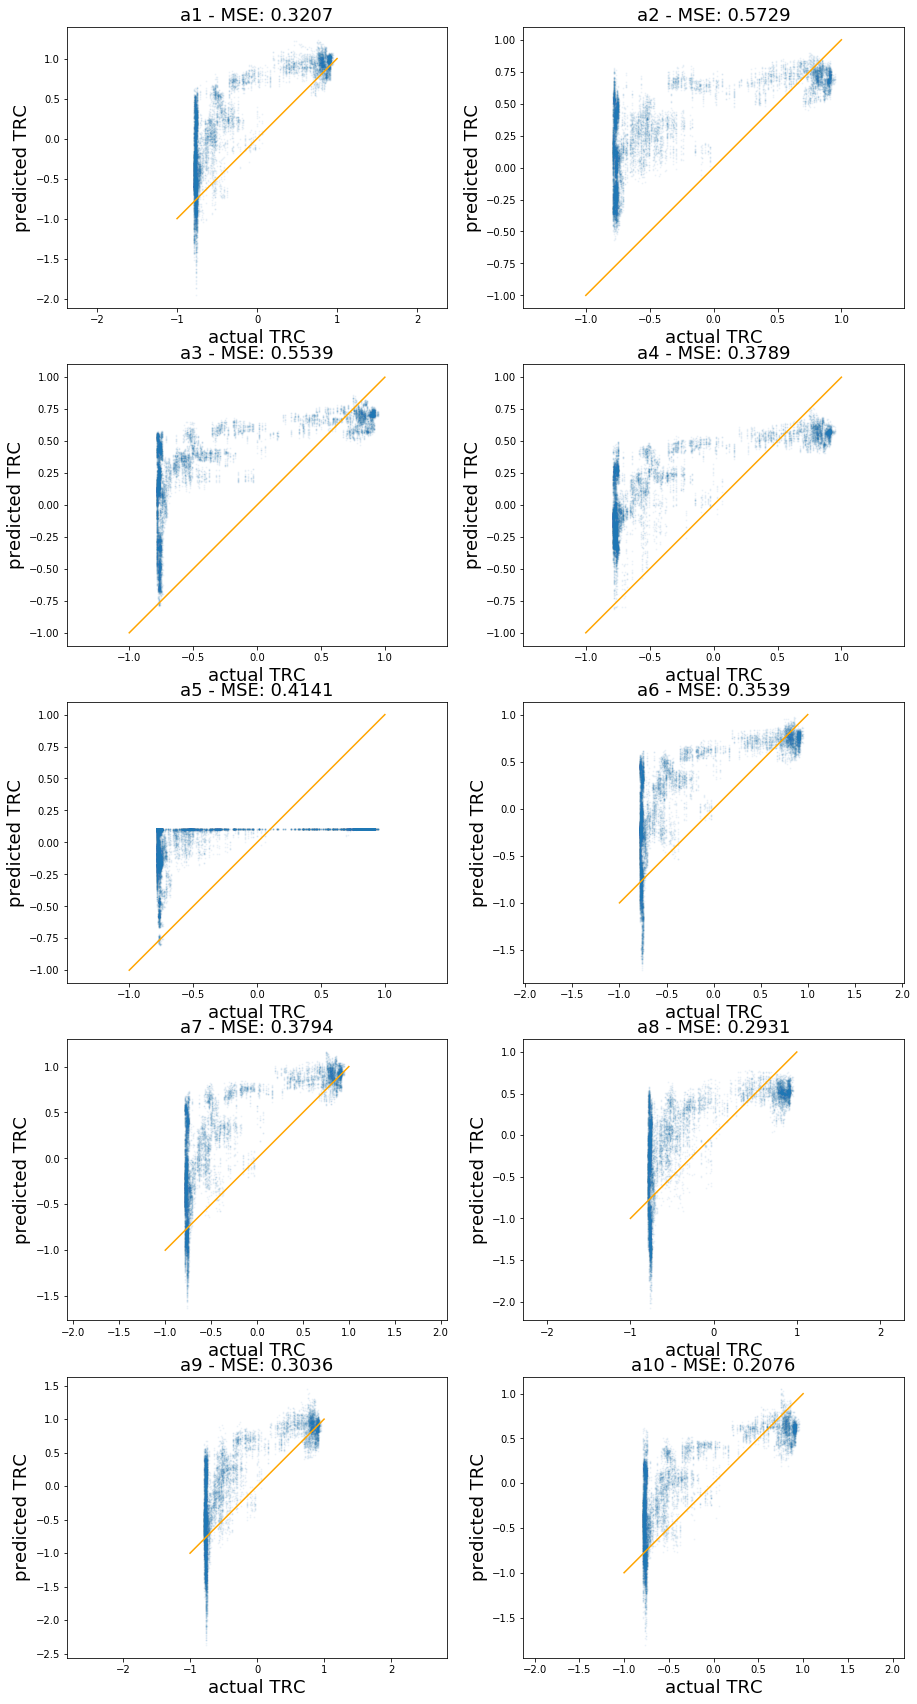

In [14]:
fig = plt.figure(figsize=(15,30))
for i, (name, model, score) in enumerate(models):
    tst_df['pred'] = model.predict(tst_x, batch_size=128, verbose=True)
    cleaned = tst_df
    ax = fig.add_subplot(5,2,i+1)
    ax.set_title(f'{name} - MSE: {score[0].round(4)}', fontsize=18)
    ax.set_xlabel(f'actual TRC', fontsize=18)
    ax.set_ylabel(f'predicted TRC', fontsize=18)
    plt.axis('equal')
    plt.scatter(cleaned['y'],cleaned['pred'], s=1, alpha=0.05)
    plt.plot([-1,1],[-1,1], c='orange')

In [ ]:
show_some(tst_df[tst_df['y'] < -0.8])

### Confusion Matrix

In [ ]:
#fig = plt.figure(figsize=(10,20))
for i, (name, model, score) in enumerate(models):
    uns_df = pd.concat([tst_df, val_df], axis=0)
    uns_x, uns_y = assemble.df_to_xy(uns_df, transform_conf=tconf)
    pred_y = model.predict(uns_x, batch_size=128, verbose=True)
    pred_y = [1 if y >= 0.5 else 0 for y in pred_y]
    cmat = confusion_matrix(uns_y, pred_y, labels=[0, 1])
    print(cmat)
#     cleaned = tst_df
#     fig.add_subplot(5,2,i+1, title=name)
#     plt.axis('equal')
#     plt.scatter(cleaned['y'],cleaned['pred'], s=1)
#     plt.plot([-1,1],[-1,1], c='orange')

In [ ]:
plt.hist(pd.concat([tst_df, val_df], axis=0)['y'])

### Predict

In [ ]:
model = [m for n, m, _ in models if n == 'a10'][0]

In [ ]:
trn_eval = model.evaluate(trn_x, trn_y, batch_size=128)
val_eval = model.evaluate(val_x, val_y, batch_size=128)
tst_eval = model.evaluate(tst_x, tst_y, batch_size=128)
print(trn_eval)
print(val_eval)
print(tst_eval)

In [ ]:
res = model.predict(tst_x, batch_size=64, verbose=1)
tst_df['pred'] = res
tst_df['sq_err'] = (tst_df['y'] - tst_df['pred']) ** 2

In [ ]:
print(np.max(res))
print(np.min(res))

In [ ]:
_ = plt.hist(res,bins=100)
_ = plt.hist(tst_y,bins=100)


In [ ]:
show_some(tst_df[(tst_df['y'] < 0.9)&(tst_df['pred'] > 0)])

In [ ]:
(500 - np.average(df['y'])) / np.std(df['y'])

### Cream of the Crap

In [ ]:
crap = tst_df.sort_values('y')[:100]
cream = tst_df.sort_values('y')[-100:]

In [ ]:
cream_x, cream_y = assemble.df_to_xy(cream, tconf)
crap_x, crap_y = assemble.df_to_xy(crap, tconf)

In [ ]:
cream_pred = model.predict(cream_x)

In [ ]:
crap_pred = model.predict(crap_x)

In [ ]:
print(np.min(cream_pred),np.mean(cream_pred),np.max(cream_pred))
print(np.min(crap_pred),np.mean(crap_pred),np.max(crap_pred))

In [ ]:
show_some(tst_df[(tst_df['y'] == 1) & (tst_df['pred'] < 0.5) ])

In [ ]:
fig = plt.figure(figsize=(10,20))
for i, (name, model, score) in enumerate(models):
    ntrn_df = pd.concat([tst_df, val_df])
    ntrn_x, _ = 
    tst_df['pred'] = model.predict(tst_x, batch_size=128, verbose=True)
    cleaned = tst_df
    fig.add_subplot(5,2,i+1, title=name)
    plt.axis('equal')
    plt.scatter(cleaned['y'],cleaned['pred'], s=1)
    plt.plot([-1,1],[-1,1], c='orange')

In [ ]:
show_some(tst_df[ (tst_df['y']) & (tst_df['y'] > 0.0)])

In [ ]:
show_some(tst_df.sort_values('pred', ascending=False)[:200])

In [ ]:
scans = [(sam, scan) for sam, scan in set(zip(tst_df['sample'],tst_df['scan'])) ]#if scan.startswith('local')]
scans

In [ ]:
set(tst_df['sample'])

In [ ]:
s_smp, s_scn = scans[14]
ex = tst_df[(tst_df['sample'] == s_smp) & (tst_df['scan'] == s_scn)]

In [ ]:
ex2 = ex.drop('img', axis=1).groupby('time').mean()

In [ ]:
plt.scatter(ex2.index.time, ex2['y'], c='r', marker='.')
plt.scatter(ex2.index.time, ex2['pred'], c='b', marker='.')
plt.plot(ex2.index.time, [0.5 for x in ex2.index.time])
# fig = plt.figure(figsize=(30,30))
# for i, (smp, scn) in enumerate(scans):
#     fig.add_subplot(3,len(scans)//3+1,i+1)
#     plt.scatter(ex2.index.time, ex2['y'], c='r', marker='.')
#     plt.scatter(ex2.index.time, ex2['pred'], c='b', marker='.')

In [ ]:
show_some(ex.sort_values('y',ascending=True)[:10])